In [1]:
import Dataset as ds
import config as cfg

from sklearn.model_selection import train_test_split
import os
from tqdm.auto import tqdm
import os
import shutil
import yaml

In [2]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

In [3]:
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
class_names = cfg.CLF_CLASS_NAMES


_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)


Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


In [4]:
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

Label correction completed.


In [5]:

augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/250 [00:00<?, ?it/s]

An error occurred: Expected y_min for bbox (0.2884145, -0.02099200000000001, 0.7555054999999999, 0.290402, 2) to be in the range [0.0, 1.0], got -0.02099200000000001.


In [6]:
## re-organise dataset for keras

def reorganize_dataset_for_keras(dataset_dir):
    
    # extract dataset name
    dataset_name = os.path.basename(dataset_dir)
    
    # Load class names from the base YAML file
    base_yaml_path = os.path.join(dataset_dir, f'{dataset_name}.yaml')
    with open(base_yaml_path) as f:
        base_data = yaml.load(f, Loader=yaml.FullLoader)
    class_names = base_data['names']

    # Function to create class subdirectories and move images
    def organize_images(base_path, label_rel_path):
        for class_id, class_name in class_names.items():
            # Create class subdirectories within the image directories
            class_image_dir = os.path.join(base_path, class_name)
            os.makedirs(class_image_dir, exist_ok=True)

        # Move images to their class subdirectories based on label files
        label_dir = os.path.join(dataset_dir, label_rel_path)
        for label_file in os.listdir(label_dir):
            # Read the label to get the class ID
            with open(os.path.join(label_dir, label_file), 'r') as file:
                class_id = int(file.readline().split()[0])

            class_name = class_names[class_id]
            image_file = label_file.replace('.txt', '.jpg')
            source_image_path = os.path.join(base_path, image_file)
            dest_image_path = os.path.join(base_path, class_name, image_file)

            if os.path.isfile(source_image_path):
                shutil.move(source_image_path, dest_image_path)

    # Organize the images in train, train-aug, and val directories
    organize_images(os.path.join(dataset_dir, 'images', 'train'), 'labels/train')
    organize_images(os.path.join(dataset_dir, 'images', 'train-aug'), 'labels/train-aug')
    organize_images(os.path.join(dataset_dir, 'images', 'valid'), 'labels/valid')

reorganize_dataset_for_keras(dataset_dir)

# Model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255)
train_aug_datagen = ImageDataGenerator(rescale=1./255)  # You can include augmentation parameters here if needed
val_datagen = ImageDataGenerator(rescale=1./255)

# Assuming 'dataset_base_dir' is the base directory where your 'train', 'train-aug', and 'valid' directories are located
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'images', 'train'),
    target_size=(224, 224),  # Adjust depending on your model's expected input size
    batch_size=32,
    class_mode='categorical')

train_aug_generator = train_aug_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'images', 'train-aug'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'images', 'valid'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')



Found 500 images belonging to 3 classes.
Found 749 images belonging to 3 classes.
Found 100 images belonging to 3 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')  # Change the number of units to match the number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\github\Third-Year-Project\Intruder-Aircraft-Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # This should be the number of batches per epoch
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50  # This should be the number of validation batches
)

Epoch 1/5


c:\github\Third-Year-Project\Intruder-Aircraft-Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 16/100 ━━━━━━━━━━━━━━━━━━━━ 1:00 726ms/step - accuracy: 0.3105 - loss: 14.3140

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.3437 - loss: 8.8878 - val_accuracy: 0.3500 - val_loss: 1.0977
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.3258 - loss: 1.0969 - val_accuracy: 0.3500 - val_loss: 1.1370
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.3640 - loss: 1.1125 - val_accuracy: 0.3500 - val_loss: 1.0946
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.3465 - loss: 1.0940 - val_accuracy: 0.3300 - val_loss: 1.0881
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.3964 - loss: 1.0863 - val_accuracy: 0.3300 - val_loss: 1.0877


In [10]:
# Save the model
model.save('../logs/Custom/my_classifier_model.h5')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.3601 - loss: 1.0820
Validation loss: 1.0876837968826294
Validation accuracy: 0.33000001311302185


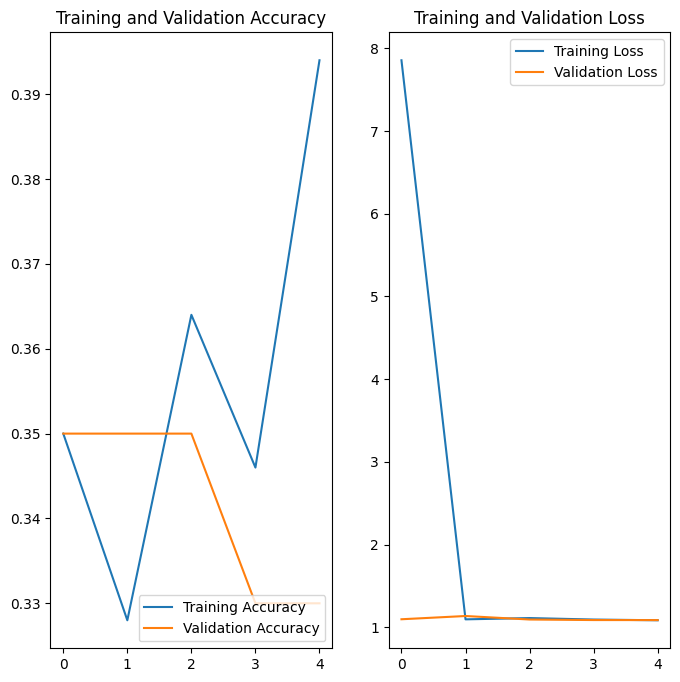

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()